In [25]:
%config Completer.use_jedi=False
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from importlib import reload


#import lnPi.old
import lnPi
import lnPi.stability

import lnPi.collectionlnpiutils



# function to convert from CH3 units to standard units

import json
kB = 1.3806503E-23 #J/K
Na = 6.02214199E23 #1/mol
kg = 1.66054E-27 #1/amu
hPlanck = 6.62606876E-34 #Js


def get_lnz(path):
    with open(path) as f:
        metadata = json.load(f)

    deBroglie = hPlanck/np.sqrt(2. * np.pi * (metadata["mass"]*kg) * kB * (metadata["T*"]*metadata["eps_kB"])) * 1.e10 #ang

    mu = metadata['mu*'] + 3. * metadata['T*'] * np.log(metadata["sigma"]/deBroglie)
    temp = metadata['T*']

    lnz = mu / temp
    
    return lnz, {'beta': 1.0 / temp, 'volume' : metadata['V*']}


# Basics

In [30]:
# get meta data
lnz, state_kws = get_lnz('t150.metadata.json')
print(state_kws)

# read in potential energy
pe = pd.read_csv('./ljsf.t150.bulk.v512.r1.energy.dat', header=None, sep='\s+', names=['n','e'])['e'].values

{'beta': 0.6666666666666666, 'volume': 512.0}


In [31]:
# create MaskedlnPi object -> New style
ref = lnPi.MaskedlnPiDelayed.from_table('./ljsf.t150.bulk.v512.r1.lnpi.dat', 
                                 fill_value=np.nan, 
                                 lnz=lnz,
                                 # state_kws needs to be defined if want to calculate some properties
                                 # down the road
                                 state_kws=state_kws, 
                                 # extra_kws is where you pass things which will be passed along to
                                 # new lnPis, like potential energy
                                 extra_kws={'PE':pe})


# zero out the max value.
# this is not neccessary, but not a bad idea either
ref = ref.zeromax()

# pad missing values of lnPi
# again, not usually needed, but can be important for 
# multicomponent lnPi's during segmenting
ref = ref.pad()

# create a phase_creator object.
# this provides some 
# factory functions for reweighting, and segmenting lnPi
phase_creator= lnPi.segment.PhaseCreator(nmax=1, nmax_peak=4, ref=ref, 
                                         merge_kws=dict(efac=0.8), 
                                         # if want to id phases based on some
                                         # callable, then set this.
                                         # the callable is passes a list of 
                                         # MaskedlnPi objects, and should return 
                                         # a list of phaseid 
                                         tag_phases=None
                                         #tag_phases=tag_phases2
                                        )

# choose a particular factory method for creating phases
build_phases = phase_creator.build_phases_mu([None])

In [37]:
# for big builds, take advantage of progress bar, and parallel builds
lnzs = np.linspace(-10, 3.5, 2000)

# by default, progress bar hides itself after completion.  use context manager to keep it
# note that for this example (where only have a single phase), doesn't really make a difference
with lnPi.set_options(tqdm_leave=True, joblib_use=False, tqdm_bar='default'):
    o = lnPi.CollectionlnPi.from_builder(lnzs, build_phases)

build:   0%|          | 0/2000 [00:00<?, ?it/s]

In [38]:
def get_test_table(o, ref):
    return o.xge.table(keys=['betaOmega','nvec','PE','dens','betaF','S','betaG','edge_distance'], ref=ref).to_dataframe().reset_index()#.to_csv('data_0.csv', index=False)

In [39]:
get_test_table(o, ref).to_csv('data_0.csv', index=False)

pi_norm:   0%|          | 0/2000 [00:00<?, ?it/s]

# Canoncial properties

 * Canonical properties are attached to MaskedlnPi objects throught the xcan attribute. 
 * just pick one and go.  Same regardless of lnz choosen

In [40]:
(
    ref.xce.table(keys=['S','Z','betaE','betaF','betaOmega','betamu','dens','ntot']).to_dataframe().reset_index()
    .to_csv('data_0_can.csv', index=False)
)

In [41]:
# available properties
print([x for x in dir(ref.xce) if x[0] != '_'] )

['PE', 'PE_n', 'S', 'S_n', 'Z', 'betaE', 'betaE_n', 'betaF', 'betaF_n', 'betaOmega', 'betaOmega_n', 'betamu', 'betapV', 'dens', 'ncoords', 'ntot', 'nvec', 'pressure', 'table']


In [42]:
ref.xce.betaF()

<xarray.DataArray 'betaF' (n_0: 436)>
array([   0.        ,   -6.23817948,  -11.78825896,  -16.93743845,
        -21.80391793,  -26.45169741,  -30.92217689,  -35.24305637,
        -39.43488586,  -43.51427534,  -47.49263482,  -51.3802843 ,
        -55.18540378,  -58.91534327,  -62.57494275,  -66.17037223,
        -69.70504171,  -73.18350119,  -76.61015068,  -79.98718016,
        -83.31692964,  -86.60257912,  -89.8454786 ,  -93.04802809,
        -96.21263757,  -99.34036705, -102.43368653, -105.49306601,
       -108.5203955 , -111.51717498, -114.48366446, -117.42170394,
       -120.33183342, -123.21554291, -126.07309239, -128.90524187,
       -131.71352135, -134.49843083, -137.26048032, -140.0003198 ,
       -142.71866928, -145.41596876, -148.09328824, -150.75033773,
       -153.38838721, -156.00779669, -158.60911617, -161.19235565,
       -163.75846514, -166.30706462, -168.8393841 , -171.35487358,
       -173.85522306, -176.33899255, -178.80819203, -181.26244151,
       -183.70210099, -186.12725047, -188.53863996, -190.93596944,
       -193.32005892, -195.6906584 , -198.04822788, -200.39366737,
       -202.72645685, -205.04623633, -207.35395581, -209.64960529,
       -211.93391478, -214.20585426, -216.46667374, -218.71597322,
       -220.9550527 , -223.18332219, -225.40031167, -227.60704115,
       -229.80326063, -231.98917011, -234.1650796 , -236.33078908,
...
       -517.57634594, -516.70443742, -515.8063279 , -514.88603639,
       -513.93637587, -512.95905135, -511.95257783, -510.91577731,
       -509.8561921 , -508.76502588, -507.64792636, -506.49973331,
       -505.32308209, -504.11578421, -502.88146288, -501.61907936,
       -500.32342584, -498.99915233, -497.64648581, -496.25981229,
       -494.84338477, -493.39481425, -491.91429574, -490.39921822,
       -488.8508627 , -487.27222118, -485.66168466, -484.01847615,
       -482.34284843, -480.63193791, -478.89023839, -477.11274027,
       -475.29930056, -473.44842984, -471.56710749, -469.6462433 ,
       -467.68825729, -465.6964695 , -463.66638676, -461.59751234,
       -459.49117603, -457.35434961, -455.17433569, -452.95667897,
       -450.70189785, -448.40261144, -446.07120492, -443.6974159 ,
       -441.28684118, -438.83551406, -436.34514405, -433.80612803,
       -431.23135871, -428.61769449, -425.95531147, -423.25743386,
       -420.51563787, -417.72985682, -414.90105215, -412.03128963,
       -409.12353928, -406.16320457, -403.15736475, -400.10615663,
       -397.01065581, -393.87252309, -390.68368018, -387.44808786,
       -384.16527904, -380.83505572, -377.4540159 , -374.02668999,
       -370.54602357, -367.02674195, -363.45618333, -359.83096831,
       -356.1615208 , -352.43810628, -348.66757176, -344.83638224])
Coordinates:
    beta     float64 0.6667
    volume   float64 512.0
  * n_0      (n_0) int64 0 1 2 3 4 5 6 7 8 ... 428 429 430 431 432 433 434 435
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'beta', 'volume']
    dims_rec:       []
    standard_name:  helmholtz_free_energy
    long_name:      $\beta F({\bf n},V,T)$

In [43]:
# table of properties
ref.xce.table(keys=['PE'], 
              # has default keys which can be set with
              # default_keys=[...]
             )

<xarray.Dataset>
Dimensions:  (n_0: 436, component: 1)
Coordinates:
  * n_0      (n_0) int64 0 1 2 3 4 5 6 7 8 ... 428 429 430 431 432 433 434 435
    beta     float64 0.6667
    volume   float64 512.0
Dimensions without coordinates: component
Data variables:
    PE       (n_0) float64 4.246e-10 4.247e-10 ... -1.649e+03 -1.654e+03
    betamu   (component, n_0) float64 -6.238 -5.894 -5.35 ... 3.747 3.801 3.831
    betapV   (n_0) float64 -0.0 0.344 1.089 ... 1.975e+03 1.998e+03 2.011e+03
    PE_n     (n_0) float64 inf 4.247e-10 -0.01052 ... -3.795 -3.799 -3.803
    betaF_n  (n_0) float64 nan -6.238 -5.894 -5.646 ... -0.8139 -0.8034 -0.7927
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'beta', 'volume']
    dims_rec:       []
    standard_name:  potential_energy
    long_name:      ${\rm PE}({\bf n},V,T)/n$

# Collection of lnPi's

In [44]:
# for big builds, take advantage of progress bar, and parallel builds
lnzs = np.linspace(-10, 3.5, 2000)

# by default, progress bar hides itself after completion.  use context manager to keep it
# note that for this example (where only have a single phase), doesn't really make a difference
with lnPi.set_options(tqdm_leave=True, joblib_use=False, tqdm_bar='text'):
    o = lnPi.CollectionlnPi.from_builder(lnzs, build_phases)

build: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 75781.27it/s]


# grand canonical properties

* Grand canonical properties are attached to CollectionlnPi objects. 
* Behind the scense, are master xarray.DataArray of lnPi's is created (x.xgce.lnpi).  This is not cached
* Pi(N) (attribute x.xgce.pi_norm) is cached for fast future calculations
* So the time consuming parti is creation of Pi(N), but further calcs are very fast

In [45]:
# available attributes/methods
print([x for x in dir(o.xge) if x[0] != '_'])

['PE', 'PE_n', 'S', 'S_n', 'Z', 'argmax', 'beta', 'betaE', 'betaE_n', 'betaF', 'betaF_alt', 'betaF_n', 'betaG', 'betaG_n', 'betaOmega', 'betaOmega_n', 'betamu', 'betapV', 'coords_state', 'dens', 'dens_tot', 'dims_comp', 'dims_lnz', 'dims_n', 'dims_rec', 'dims_state', 'edge_distance', 'edge_distance_val', 'lnpi', 'lnpi_max', 'lnpi_norm', 'lnz', 'mask_stable', 'max', 'mean_pi', 'molfrac', 'ncoords', 'ncoords_tot', 'ntot', 'ntot_var', 'nvec', 'nvec_var', 'pi_norm', 'pi_norm_max', 'pi_sum', 'pipe', 'pressure', 'table', 'var_pi', 'volume']


In [46]:
o.xge.betaOmega()

pi_norm:   0%|          | 0/2000 [00:00<?, ?it/s]

<xarray.DataArray 'betaOmega' (lnz_0: 2000, phase: 1)>
array([[-2.32427562e-02],
       [-2.34002638e-02],
       [-2.35588389e-02],
       ...,
       [-1.86516098e+03],
       [-1.86804678e+03],
       [-1.87093336e+03]])
Coordinates:
  * lnz_0    (lnz_0) float64 -10.0 -9.993 -9.986 -9.98 ... 3.48 3.486 3.493 3.5
  * phase    (phase) int64 0
    beta     float64 0.6667
    volume   float64 512.0
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'beta', 'volume']
    dims_rec:       ['sample']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

In [47]:
# table
o.xge.table(keys=['PE', 'dens'], 
            # by setting ref, calculate edge distance for each sample
            ref=ref,
            # by setting mask_stable, return only the stable phase
            mask_stable=True,
           )

<xarray.Dataset>
Dimensions:        (lnz_0: 2000, component: 1)
Coordinates:
  * lnz_0          (lnz_0) float64 -10.0 -9.993 -9.986 -9.98 ... 3.486 3.493 3.5
    beta           float64 0.6667
    volume         float64 512.0
    phase          (lnz_0) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: component
Data variables:
    edge_distance  (lnz_0) float64 436.0 436.0 436.0 436.0 ... 9.0 8.0 8.0 8.0
    PE             (lnz_0) float64 -5.712e-06 -5.789e-06 ... -1.612e+03
    dens           (component, lnz_0) float64 4.54e-05 4.571e-05 ... 0.8349
    nvec           (component, lnz_0) float64 0.02324 0.0234 ... 427.4 427.5
    betapV         (lnz_0) float64 0.02324 0.0234 ... 1.868e+03 1.871e+03
    PE_n           (lnz_0) float64 -0.0002457 -0.0002474 ... -3.769 -3.77

# comparison xcan/xgce

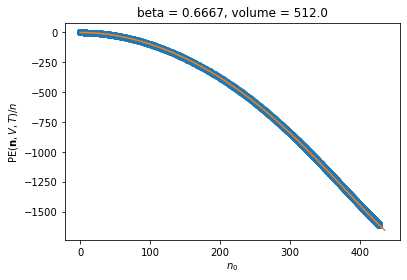

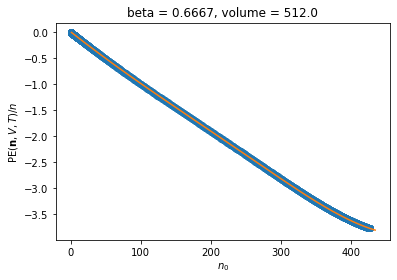

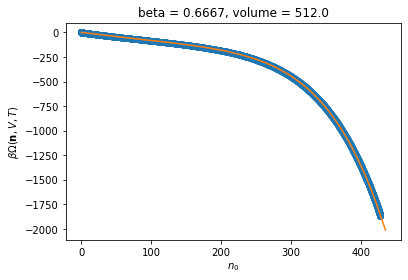

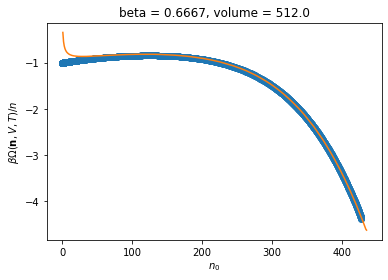

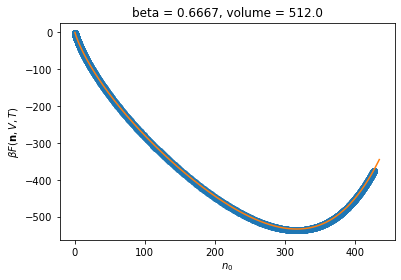

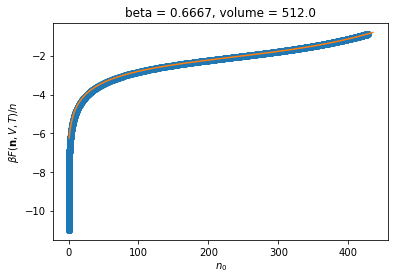

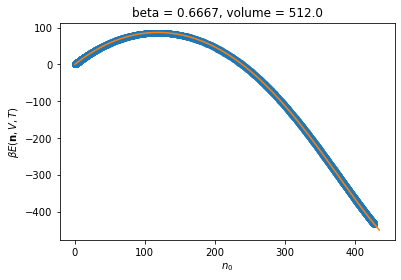

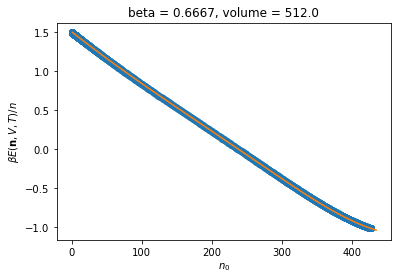

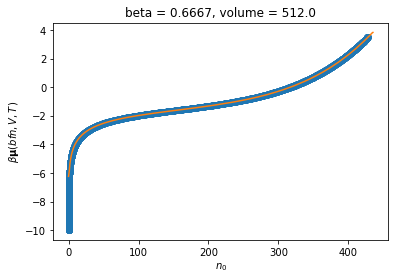

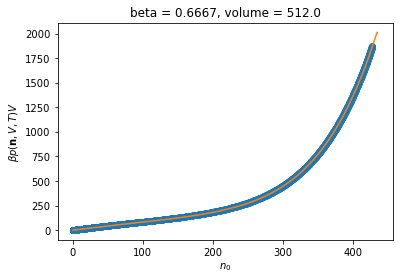

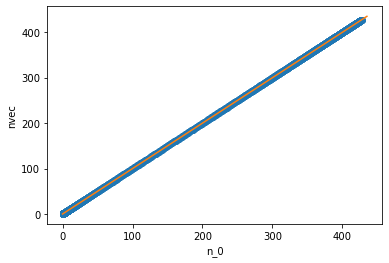

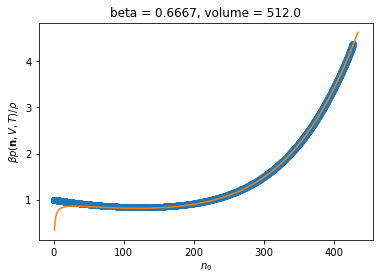

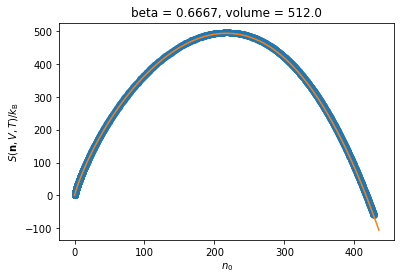

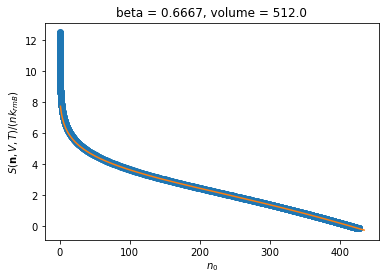

In [48]:
for prop in ['PE','PE_n', 'betaOmega', 'betaOmega_n', 'betaF', 'betaF_n', 'betaE','betaE_n', 'betamu', 'betapV',
             'nvec','Z', 'S','S_n']:

    fig, ax = plt.subplots()
    (
        o.xge.table(['ntot',prop], default_keys=[]).min('phase')
        .set_coords('ntot')
        .swap_dims({'lnz_0':'ntot'})
        [prop]
        .plot(label='grand canonical', marker='o')
    )

    (
        ref.xce.table([prop], default_keys=[])
        [prop]
        .plot()
    )

# comparison to old results

In [16]:
df = (
    pd.read_csv('./T_1.50_EOS.csv')
    .rename(columns=lambda x: x.replace('*','').replace('<','').replace('>','').replace(')','').replace('(',''))
    .rename(columns={'lnz':'lnz_0','rho':'dens','p':'pressure','U':'PE'})
)
    
df.head()

,T,V,Rcut,TAIL,lnz_0,dens,stdev,pressure,stdev.1,PE,stdev.2
0,1.5,512.0,2.5,LFS,-6.910147,0.00100,3.196241e-08,0.001498,8.859471e-08,-0.002772,0.000002
1,1.5,512.0,2.5,LFS,-6.900367,0.00101,3.193346e-08,0.001513,8.900519e-08,-0.002827,0.000002
2,1.5,512.0,2.5,LFS,-6.890587,0.00102,3.190516e-08,0.001528,8.941257e-08,-0.002882,0.000002
3,1.5,512.0,2.5,LFS,-6.880808,0.00103,3.187785e-08,0.001543,8.981673e-08,-0.002940,0.000002
4,1.5,512.0,2.5,LFS,-6.871028,0.00104,3.185190e-08,0.001558,9.021756e-08,-0.002998,0.000002


In [17]:
# build nice grid
import lnPi.collectionlnpiutils
with lnPi.set_options(joblib_use=True):
    o_course, o = lnPi.collectionlnpiutils.limited_collection(build_phases, dlnz=0.01, offsets=[-10, +10], 
                                                    even_grid=True, # but lnzs on same grid as dlnz
                                                    digits=2, #round lnzs to this number of digits
                                                    edge_distance_min=10, dens_min=0.001)

build:   0%|          | 0/1035 [00:00<?, ?it/s]

In [18]:
get_test_table(o_course, ref).to_csv('data_0_course.csv', index=False)
get_test_table(o, ref).to_csv('data_0_fine.csv', index=False)

pi_norm:   0%|          | 0/1035 [00:00<?, ?it/s]

In [19]:
o3 = lnPi.CollectionlnPi.from_builder(df['lnz_0'].values, build_phases)

build:   0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
table = (
    o3.xge.table(['dens','pressure','PE','betamu'], default_keys=[], ref=ref)
    .sel(phase=0,component=0)
    .to_dataframe()
    .reset_index()
)

pi_norm:   0%|          | 0/1000 [00:00<?, ?it/s]

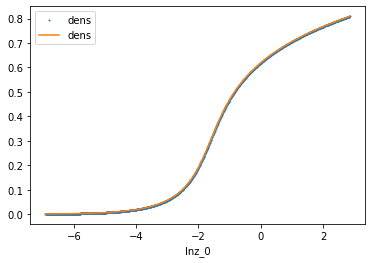

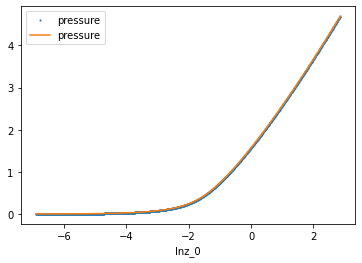

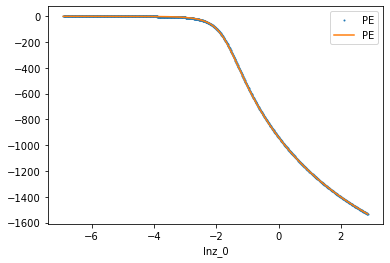

In [21]:
for col in ['dens','pressure','PE']:
    fig, ax = plt.subplots()
    df.plot('lnz_0',col, marker='o', mfc=None, ls='None', ax=ax, ms=1)
    table.plot('lnz_0',col, ax=ax, color='tab:orange')

# Multiple phases (sub critical)

In [49]:
%config Completer.use_jedi=False
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from importlib import reload


#import lnPi.old
import lnPi
import lnPi.stability

import lnPi.collectionlnpiutils



# function to convert from CH3 units to standard units

import json
kB = 1.3806503E-23 #J/K
Na = 6.02214199E23 #1/mol
kg = 1.66054E-27 #1/amu
hPlanck = 6.62606876E-34 #Js


def get_lnz(path):
    with open(path) as f:
        metadata = json.load(f)

    deBroglie = hPlanck/np.sqrt(2. * np.pi * (metadata["mass"]*kg) * kB * (metadata["T*"]*metadata["eps_kB"])) * 1.e10 #ang

    mu = metadata['mu*'] + 3. * metadata['T*'] * np.log(metadata["sigma"]/deBroglie)
    temp = metadata['T*']

    lnz = mu / temp
    
    return lnz, {'beta': 1.0 / temp, 'volume' : metadata['V*']}


In [50]:
#function to tag 'LD' and 'HD' phases
def tag_phases2(x):
    if len(x) > 2:
        raise ValueError('bad tag function')
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)


In [51]:
# get meta data
lnz, state_kws = get_lnz('./t072871.metadata.json')
pe = pd.read_csv('./ljsf.t072871.bulk.v512.r1.energy.dat', header=None, sep='\s+', names=['n','e'])['e'].values
ref = lnPi.MaskedlnPiDelayed.from_table('./ljsf.t072871.bulk.v512.r1.lnpi.dat',
                                 fill_value=np.nan, 
                                 lnz=lnz,
                                 state_kws=state_kws, 
                                 extra_kws={'PE':pe}).zeromax().pad()


# Note that here, nmax=2, and we specify tag_phases
phase_creator= lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=ref, 
                                         merge_kws=dict(efac=0.8), 
                                         tag_phases=tag_phases2
                                        )

# choose a particular factory method for creating phases
build_phases = phase_creator.build_phases_mu([None])

In [66]:
p = phase_creator.build_phases()

In [73]:
p.get_index_level('phase')

Int64Index([0, 1], dtype='int64', name='phase')

In [70]:
p._concat_coords

'different'

In [65]:
p.xge.coords_state

{'lnz_0': <xarray.DataArray 'lnz_0' (sample: 2)>
 array([-3.609956, -3.609956])
 Coordinates:
   * sample   (sample) object MultiIndex
   * lnz_0    (sample) float64 -3.61 -3.61
   * phase    (sample) int64 0 1
     beta     float64 1.372
     volume   float64 512.0,
 'beta': <xarray.DataArray 'beta' ()>
 array(1.37228802)
 Coordinates:
     beta     float64 1.372
     volume   float64 512.0,
 'volume': <xarray.DataArray 'volume' ()>
 array(512.)
 Coordinates:
     beta     float64 1.372
     volume   float64 512.0}

In [64]:
for k in dict.fromkeys([1,2,3,3]):
    print(k)

1
2
3


In [58]:
p.wlnPi.get_dwx(0)

<xarray.DataArray 'delta_w' (lnz_0: 1)>
array([6.601764])
Coordinates:
  * lnz_0    (lnz_0) float64 -3.61
    phase    int64 0

In [26]:
(
    ref.xce.table(keys=['S','Z','betaE','betaF','betaOmega','betamu','dens','ntot']).to_dataframe().reset_index()
    .to_csv('data_1_can.csv', index=False)
)

## parallel builds

In [27]:
lnzs = np.linspace(-10, 3, 2000)

In [28]:
#slow
with lnPi.set_options(tqdm_leave=True, joblib_use=False):
    o = lnPi.CollectionlnPi.from_builder(lnzs, build_phases)

build:   0%|          | 0/2000 [00:00<?, ?it/s]

In [29]:
#%%timeit -n 1 -r 1
#fast 
with lnPi.set_options(tqdm_leave=True, joblib_use=True):
    o2 = lnPi.CollectionlnPi.from_builder(lnzs, build_phases)
#     a = o.xge.table()
#     o.spinodal(2, build_phases)
#     o.binodal(2, build_phases)    

build:   0%|          | 0/2000 [00:00<?, ?it/s]

In [30]:
xr.testing.assert_allclose(o2.xge.betaOmega(), o.xge.betaOmega())

pi_norm:   0%|          | 0/2138 [00:00<?, ?it/s]

pi_norm:   0%|          | 0/2138 [00:00<?, ?it/s]

In [31]:
get_test_table(o2, ref).to_csv('data_1.csv', index=False)

## stacked vs unstacked

In [26]:
lnzs = np.linspace(-10, 3, 20)

# unstack is default behavior
o_unstacked = lnPi.CollectionlnPi.from_builder(lnzs, build_phases, unstack=True)

# pass unstack = False
o_stacked = lnPi.CollectionlnPi.from_builder(lnzs, build_phases, unstack=False)

In [27]:
# unstack results
o_unstacked.xge.dens

<xarray.DataArray 'dens' (component: 1, lnz_0: 20, phase: 2)>
array([[[4.54122341e-05,            nan],
        [9.00659216e-05,            nan],
        [1.78724194e-04,            nan],
        [3.55037718e-04,            nan],
        [7.06808827e-04,            nan],
        [1.41324537e-03,            nan],
        [2.85107412e-03,            nan],
        [5.86258523e-03,            nan],
        [1.26156786e-02,            nan],
        [3.14809935e-02, 7.21258469e-01],
        [           nan, 7.69245441e-01],
        [           nan, 8.02630469e-01],
        [           nan, 8.29147738e-01],
        [           nan, 8.44711654e-01],
        [           nan, 8.48195862e-01],
        [           nan, 8.49053617e-01],
        [           nan, 8.49359302e-01],
        [           nan, 8.49489945e-01],
        [           nan, 8.49550725e-01],
        [           nan, 8.49580181e-01]]])
Coordinates:
    beta     float64 1.372
    volume   float64 512.0
  * lnz_0    (lnz_0) float64 -10.0 -9.316 -8.632 -7.947 ... 1.632 2.316 3.0
  * phase    (phase) int64 0 1
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'beta', 'volume']
    dims_rec:    ['sample']
    long_name:   ${\bf \rho}(\mu,V,T)$

In [28]:
# stacked results
o_stacked.xge.dens

<xarray.DataArray 'dens' (sample: 21, component: 1)>
array([[4.54122341e-05],
       [9.00659216e-05],
       [1.78724194e-04],
       [3.55037718e-04],
       [7.06808827e-04],
       [1.41324537e-03],
       [2.85107412e-03],
       [5.86258523e-03],
       [1.26156786e-02],
       [3.14809935e-02],
       [7.21258469e-01],
       [7.69245441e-01],
       [8.02630469e-01],
       [8.29147738e-01],
       [8.44711654e-01],
       [8.48195862e-01],
       [8.49053617e-01],
       [8.49359302e-01],
       [8.49489945e-01],
       [8.49550725e-01],
       [8.49580181e-01]])
Coordinates:
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -10.0 -9.316 -8.632 -7.947 ... 1.632 2.316 3.0
  - phase    (sample) int64 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
    beta     float64 1.372
    volume   float64 512.0
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'beta', 'volume']
    dims_rec:    ['sample']
    long_name:   ${\bf \rho}(\mu,V,T)$

In [29]:
# its trivial to go from one to the other that to take an stacked array to unstacked
o_stacked.xge.dens.unstack()

<xarray.DataArray 'dens' (component: 1, lnz_0: 20, phase: 2)>
array([[[4.54122341e-05,            nan],
        [9.00659216e-05,            nan],
        [1.78724194e-04,            nan],
        [3.55037718e-04,            nan],
        [7.06808827e-04,            nan],
        [1.41324537e-03,            nan],
        [2.85107412e-03,            nan],
        [5.86258523e-03,            nan],
        [1.26156786e-02,            nan],
        [3.14809935e-02, 7.21258469e-01],
        [           nan, 7.69245441e-01],
        [           nan, 8.02630469e-01],
        [           nan, 8.29147738e-01],
        [           nan, 8.44711654e-01],
        [           nan, 8.48195862e-01],
        [           nan, 8.49053617e-01],
        [           nan, 8.49359302e-01],
        [           nan, 8.49489945e-01],
        [           nan, 8.49550725e-01],
        [           nan, 8.49580181e-01]]])
Coordinates:
    beta     float64 1.372
    volume   float64 512.0
  * lnz_0    (lnz_0) float64 -10.0 -9.316 -8.632 -7.947 ... 1.632 2.316 3.0
  * phase    (phase) int64 0 1
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'beta', 'volume']
    dims_rec:    ['sample']
    long_name:   ${\bf \rho}(\mu,V,T)$

In [30]:
# note that xarray carries along nan
# and reorders on unstack.  No big deal
o_unstacked.xge.dens.stack(sample=['lnz_0','phase']).dropna('sample').transpose('sample','component')

<xarray.DataArray 'dens' (sample: 21, component: 1)>
array([[4.54122341e-05],
       [9.00659216e-05],
       [1.78724194e-04],
       [3.55037718e-04],
       [7.06808827e-04],
       [1.41324537e-03],
       [2.85107412e-03],
       [5.86258523e-03],
       [1.26156786e-02],
       [3.14809935e-02],
       [7.21258469e-01],
       [7.69245441e-01],
       [8.02630469e-01],
       [8.29147738e-01],
       [8.44711654e-01],
       [8.48195862e-01],
       [8.49053617e-01],
       [8.49359302e-01],
       [8.49489945e-01],
       [8.49550725e-01],
       [8.49580181e-01]])
Coordinates:
    beta     float64 1.372
    volume   float64 512.0
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -10.0 -9.316 -8.632 -7.947 ... 1.632 2.316 3.0
  - phase    (sample) int64 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'beta', 'volume']
    dims_rec:    ['sample']
    long_name:   ${\bf \rho}(\mu,V,T)$

## comparison 

In [32]:
# build nice grid
import lnPi.collectionlnpiutils

In [33]:
o_course, o = lnPi.collectionlnpiutils.limited_collection(build_phases, dlnz=0.01, offsets=[-10, +10], 
                                                even_grid=True, # but lnzs on same grid as dlnz
                                                digits=2, #round lnzs to this number of digits
                                                edge_distance_min=10, dens_min=0.001)

build:   0%|          | 0/524 [00:00<?, ?it/s]

In [34]:
get_test_table(o_course, ref).to_csv('data_1_course.csv', index=False)
get_test_table(o, ref).to_csv('data_1_fine.csv', index=False)

pi_norm:   0%|          | 0/614 [00:00<?, ?it/s]

In [33]:
df = (
    pd.read_csv('./T_0.72871_EOS.csv')
    .rename(columns=lambda x: x.replace('*','').replace('<','').replace('>','').replace(')','').replace('(',''))
    .rename(columns={'lnz':'lnz_0','rho':'dens','p':'pressure','U':'PE'})
)
    
df.head()

,T,V,Rcut,TAIL,lnz_0,dens,stdev,pressure,stdev.1,PE,stdev.2
0,0.72871,512.0,2.5,LFS,-6.919759,0.001000,1.236298e-07,0.000724,9.518432e-08,-0.004397,0.000002
1,0.72871,512.0,2.5,LFS,-6.915094,0.001005,1.241497e-07,0.000728,9.559684e-08,-0.004439,0.000002
2,0.72871,512.0,2.5,LFS,-6.910429,0.001010,1.246715e-07,0.000731,9.601106e-08,-0.004481,0.000002
3,0.72871,512.0,2.5,LFS,-6.905764,0.001014,1.251954e-07,0.000735,9.642697e-08,-0.004523,0.000002
4,0.72871,512.0,2.5,LFS,-6.901100,0.001019,1.257213e-07,0.000738,9.684459e-08,-0.004566,0.000002


## picking stable phases

In [34]:
table = (
    o.xge.table(['dens','pressure','PE','betamu'], default_keys=[], ref=ref)
)

# note that now we have multiple phases.  want only the most stable phases...
table

<xarray.Dataset>
Dimensions:        (component: 1, lnz_0: 524, phase: 2)
Coordinates:
    beta           float64 1.372
    volume         float64 512.0
  * lnz_0          (lnz_0) float64 -6.92 -6.91 -6.9 -6.89 ... -1.71 -1.7 -1.69
  * phase          (phase) int64 0 1
Dimensions without coordinates: component
Data variables:
    edge_distance  (lnz_0, phase) float64 436.0 nan 436.0 nan ... 10.0 nan 10.0
    dens           (component, lnz_0, phase) float64 0.0009998 nan ... 0.8324
    pressure       (lnz_0, phase) float64 0.0007241 nan 0.0007314 ... nan 1.313
    PE             (lnz_0, phase) float64 -0.004394 nan ... nan -1.916e+03
    betamu         (component, lnz_0, phase) float64 -6.92 nan ... nan -1.69

In [35]:
table = (
    o.xge.table(['dens','pressure','PE','betamu'], mask_stable=True, default_keys=[], ref=ref)
    .to_dataframe()
    .reset_index()
)

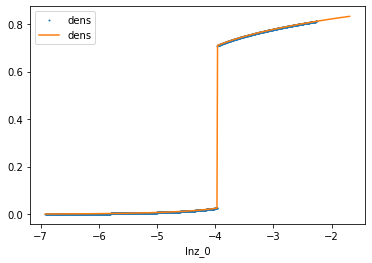

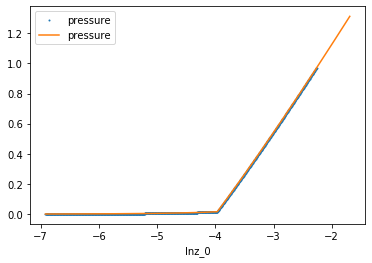

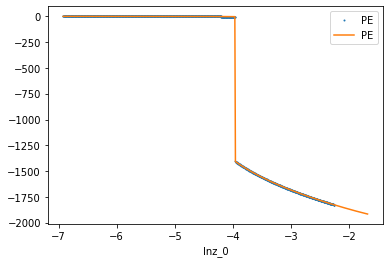

In [36]:
for col in ['dens','pressure','PE']:
    fig, ax = plt.subplots()
    df.plot('lnz_0',col, marker='o', mfc=None, ls='None', ax=ax, ms=1)
    table.plot('lnz_0',col, ax=ax, color='tab:orange')

# building stability

In [35]:
o_course.spinodal(2, build_phases)
o_course.binodal(2, build_phases)

In [36]:
get_test_table(o_course.spinodal.access, ref).to_csv('data_1_spin.csv', index=False)

In [37]:
get_test_table(o_course.binodal.access, ref).to_csv('data_1_bino.csv', index=False)

In [38]:
o_course.spinodal.access.wlnPi.dw.to_frame().reset_index().to_csv('data_1_spin_dw.csv', index=False)

In [39]:
# append to o
o_new = o.stability_append(o_course)

/Users/wpk/Documents/python/lnPi/collectionlnpi.py:127: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s = self._series.append(
/Users/wpk/Documents/python/lnPi/collectionlnpi.py:127: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s = self._series.append(


pi_norm:   0%|          | 0/620 [00:00<?, ?it/s]

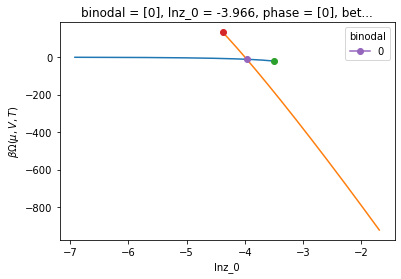

In [40]:
o_new.xge.betaOmega().plot(hue='phase')

(
    o_new.spinodal.access.xge.betaOmega()
    .pipe(lambda x: x.sel(spinodal=x.phase))
    .plot(hue='phase', marker='o')
)


(
    o_new.binodal.access.xge
    .betaOmega()
    .pipe(lambda x: x.sel(phase=x.binodal))
    .plot.line(hue='binodal', marker='o')
)